# Neural Networks

#### Some imports:

In [99]:
import numpy as np
import matplotlib.pyplot as plt

#### Some activation functions and their derivatives:

In [100]:
# rectified linear unit: this seems to be the fastest implementation using numpy's clip method
def ReLU(x): return np.clip(x,0,None)

# the (weak) derivative of ReLU, again using numpy
def Heaviside(x): return np.heaviside(x,0)

# unnecessary function call, for the sake of compactness/readability
def Id(x): return x

# makes vectorization possible, again using numpy's clip method
def One(x): return np.clip(x,1,1)

### A (multy-layer, feed-forward) neural network class:

In [101]:
class NN:
    
    # Initialize neural network of depth L=2:
    # ...
    def __init__(self, d, L=2, phi={2: ReLU,3: Id}, dphi={2: Heaviside, 3: One}):
        # check wether L, d, phi, Dphi are all compatible
        assert len(d) == L+1, "#layer dimension != #layers"
        assert len(phi) == L, "#activation functions != #layers - 1"
        assert len(dphi) == L, "#activation function derivatives != #layers - 1"
        # set parameters
        self.d, self.L   = d, L
        self.phi, self.dphi = phi, dphi
        # initialize weights
        self.W = {l: np.random.uniform(-1, 1, (d[l],d[l+1])) for l in range(1,L+1)}
        # initialize biases
        self.b = {l: np.random.uniform(-1, 1, d[l]) for l in range(2,L+2)}
        self.__o, self.__net = {}, {} 
    
    # forward propagation:  
    def feed_forward(self, x):
        # initialize input neurons
        self.__o[1] = x
        # the actual forward propagation using np.dot
        for l in range(1, self.L+1):
            self.__net[l+1] = np.dot(self.__o[l], self.W[l]) + self.b[l+1]
            self.__o[l+1] = self.phi[l+1](self.__net[l+1])
        # return output layer
        return self.__o[self.L+1].flatten()
    
    # backpropagation:
    def backpropagation(self, y):
        # check wether y has the right shape
        assert len(y) == len(self.__o[1]), "#labels != #data points"
        assert y.shape[1] == self.d[self.L+1], "dimension of output != dimension of data"
        # initialize the gradients
        gradW, gradb = {}, {}       
        # the actual backpropagation algorithm using np.einsum and np.tensordot
        delta = 2*(self.__o[self.L+1] - y)
        for l in range(1,self.L+1)[::-1]:
            gradb[l+1] = delta*self.dphi[l+1](self.__net[l+1])
            gradW[l] = np.einsum('ni,nj->nij',self.__o[l],gradb[l+1])   
            delta = np.tensordot(self.W[l], gradb[l+1], axes=[1,1]).T  
            gradb[l+1] = np.mean(gradb[l+1],axis=0)
            gradW[l] = np.mean(gradW[l],axis=0)   
        return gradW, gradb
    
    # Stochastic minibatch gradient descent: minimizes least squares loss.
    # D is the data set, 'nu' is the learning rate, K the size of the minibatch,
    # and S is the number of steps.
    def SGD(self, x, y, nu, K=20, S=50000, output=False):
        for s in range(S):
            B = np.random.choice(x.shape[0], K, replace=False)
            self.feed_forward(x[B,])
            gradW, gradb = self.backpropagation(y[B,])
            for l in range(1,self.L+1):           
                self.W[l] -= nu*gradW[l]
                self.b[l+1] -= nu*gradb[l+1]
            if output == True and not s%int(S/10):
                acc = np.mean(np.logical_and(self.__o[self.L+1].flatten() < 0, y[B,].flatten() == -1.)) + np.mean(np.logical_and(self.__o[self.L+1].flatten() >= 0, y[B,].flatten() == 1.) )
                mse = np.mean(np.square(self.__o[self.L+1].flatten()-y[B,].flatten()))
                print("{}: accuracy = {}, MSE = {}".format(s,acc,mse))
    

#### Generate random data to test the NN class:

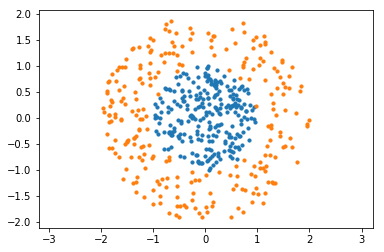

In [103]:
N = 250 # half of number of data points

# test data: uniform distribution on the unit circle
x1 = np.sqrt(np.random.rand(N))*np.exp(np.random.rand(N)*2j*np.pi)

# convert complex to 2d array 
x1 = np.stack((x1.real,x1.imag),-1)

# the same for 1≤|x|≤2
x2 = np.sqrt(np.random.uniform(1,4,N))*np.exp(np.random.rand(N)*2j*np.pi)
x2 = np.stack((x2.real,x2.imag),-1)

# put the two together
x = np.concatenate((x1,x2))

# the first 250 data points labeled -1, the second half is labeled 1
y = np.concatenate((np.full(N,-1),np.full(N,1))).reshape(500,1)

# plot the data to see if it has the right distribiution
x1plot = x[y.flatten()<0].swapaxes(0,1)
x2plot = x[y.flatten()>0].swapaxes(0,1)
fig, ax = plt.subplots()
ax.scatter(x1plot[0], x1plot[1], s=10)
ax.scatter(x2plot[0], x2plot[1], s=10)
ax.axis('equal')
plt.show()

#### Now we create a two layer NN  with a hidden layer of 20 neurons:
- The input values are from $\mathbb{R}^2$ so there must be 2 input neurons.
- The there are only two output classes, so there is only one neuron in the output layer. 

In [104]:
perceptron = NN({1: 2,2: 20,3: 1})

0: accuracy = 0.4, MSE = 1.7450384224678963
1000: accuracy = 1.0, MSE = 0.19195237791023687
2000: accuracy = 0.9500000000000001, MSE = 0.20372331639737212
3000: accuracy = 0.95, MSE = 0.24559008819290945
4000: accuracy = 1.0, MSE = 0.14752869865149063
5000: accuracy = 1.0, MSE = 0.12271303847590684
6000: accuracy = 0.9, MSE = 0.24497881885093284
7000: accuracy = 0.9, MSE = 0.22454724685601488
8000: accuracy = 0.9500000000000001, MSE = 0.12159793623853284
9000: accuracy = 1.0, MSE = 0.12007422832263175


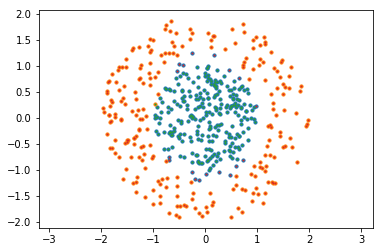

0: accuracy = 0.9500000000000001, MSE = 0.09774939262438251
1000: accuracy = 0.95, MSE = 0.20792202944050206
2000: accuracy = 1.0, MSE = 0.04284237295941603
3000: accuracy = 1.0, MSE = 0.028072070371637402
4000: accuracy = 1.0, MSE = 0.05247806167162411
5000: accuracy = 1.0, MSE = 0.08179673927268745
6000: accuracy = 0.9500000000000001, MSE = 0.13294437229345848
7000: accuracy = 0.95, MSE = 0.17398651383849356
8000: accuracy = 0.95, MSE = 0.2697046400733881
9000: accuracy = 0.9, MSE = 0.13132974286304894


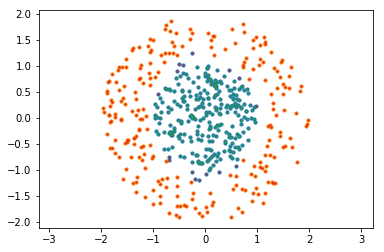

0: accuracy = 1.0, MSE = 0.03427255575586978
1000: accuracy = 0.95, MSE = 0.17636425093047806
2000: accuracy = 0.95, MSE = 0.17153588258517932
3000: accuracy = 1.0, MSE = 0.07463052838985021
4000: accuracy = 1.0, MSE = 0.04087569947333175
5000: accuracy = 1.0, MSE = 0.19281145843975112
6000: accuracy = 0.8999999999999999, MSE = 0.2178338971105776
7000: accuracy = 0.9500000000000001, MSE = 0.15455536261518657
8000: accuracy = 1.0, MSE = 0.08371026867214529
9000: accuracy = 0.95, MSE = 0.1059489691316364


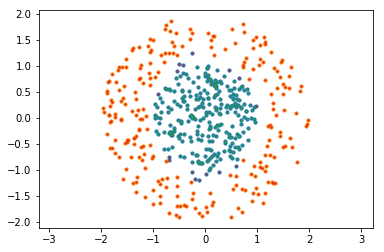

In [105]:
for nu in [.1,.001,.0001]:
    perceptron.SGD(x, y, nu, output=True)
    
    c = perceptron.feed_forward(x).reshape(500)
    c1plot = x[c<0].swapaxes(0,1)
    c2plot = x[c>0].swapaxes(0,1)
    fig, ax = plt.subplots()
    ax.scatter(c1plot[0], c1plot[1], s=10)
    ax.scatter(c2plot[0], c2plot[1], s=10)
    ax.scatter(x1plot[0], x1plot[1], s=1)
    ax.scatter(x2plot[0], x2plot[1], s=1)
    
    ax.axis('equal')
    plt.show()